# Iris test adapted from the internet

**Purpose**

Test the `skl2onnx` package on a simple example : logistic regression on iris dataset.

This script tests the following properties:

1. train simple model
2. export onnx file
3. reload model and predict using a reloaded onnx file
4. view information in onnx with a json like format
5. convert onnx to pydot graph and draw graph on an image and display 

**Reference**

http://onnx.ai/sklearn-onnx/tutorial.html : the end of that tuto is not functional

and 

http://onnx.ai/sklearn-onnx/ : test with random forest

and

http://onnx.ai/sklearn-onnx/auto_examples/plot_pipeline.html :  view json and plot'

to plot onnx documents, the electron app Netron is simple and easy to use:

https://github.com/lutzroeder/Netron

**Expected output files in chronological order**

1. logreg_iris.onnx
2. iris_graph.dot
3. iris_graph.png

## Step 1: Train a model using your favorite framework¶

We’ll use the famous Iris datasets.

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [2]:
from sklearn.linear_model import LogisticRegression
clr = LogisticRegression(solver='liblinear', multi_class='auto') 
# Params were added to avoid warning related to change of version, 
# These parameter where not optimized on the dataset
clr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

## Step 2: Convert or export the model into ONNX format¶

ONNX is a format to describe the machine learned model.

It defines a set of commonly used operators to compose models.

There are tools to convert other model formats into ONNX. Here we will use ONNXMLTools.

In [3]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

initial_type = [('float_input', FloatTensorType([1, 4]))]
onx = convert_sklearn(clr, initial_types=initial_type)

onnx_file = "logreg_iris.onnx"

with open(onnx_file, "wb") as f:
    f.write(onx.SerializeToString())

The maximum opset needed by this model is only 9.
The maximum opset needed by this model is only 1.


## Step 3: Load and run the model using ONNX Runtime

We will use ONNX Runtime to compute the predictions for this machine learning model.

In [4]:
# Compute the prediction with ONNX Runtime
import onnxruntime as rt
import numpy as np
sess = rt.InferenceSession(onnx_file)
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
pred_onx = sess.run([label_name], {input_name: X_test.astype(np.float32)})[0]

### Check

In [5]:
print(input_name, label_name)
print(pred_onx)

float_input output_label
[2 0 1 0 0 2 2 1 2 2 1 0 2 0 1 0 0 1 1 0 1 2 1 2 0 0 0 0 0 0 1 2 0 0 2 2 0
 2]


### Expected output

float_input output_label
[1 0 0 2 2 0 1 0 2 0 2 2 2 0 2 2 1 0 1 2 2 0 0 0 0 0 0 2 2 2 0 1 1 2 0 1 2 1]

## View json version

In [6]:
import onnx
onnx_model = onnx.load(onnx_file)
print(onnx_model.__str__())

ir_version: 5
producer_name: "skl2onnx"
producer_version: "1.5.1"
domain: "ai.onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "float_input"
    output: "label"
    output: "probability_tensor"
    name: "LinearClassifier"
    op_type: "LinearClassifier"
    attribute {
      name: "classlabels_ints"
      ints: 0
      ints: 1
      ints: 2
      type: INTS
    }
    attribute {
      name: "coefficients"
      floats: 0.3948916792869568
      floats: 1.3067545890808105
      floats: -2.1131019592285156
      floats: -0.951578676700592
      floats: 0.4458463490009308
      floats: -1.4048690795898438
      floats: 0.36600184440612793
      floats: -0.9445315599441528
      floats: -1.6174530982971191
      floats: -1.3608001470565796
      floats: 2.356180429458618
      floats: 2.097918748855591
      type: FLOATS
    }
    attribute {
      name: "intercepts"
      floats: 0.2728666067123413
      floats: 0.7293078899383545
      floats: -1.0498480796813965
      t

In [7]:
import json

json_test_1 = json.loads('{ "name":"John", "age":30, "city":"New York"}')
print(json_test_1)
print('')

try: 
    json_test_2 = json.loads('{ name:"John", age:30, city:"New York"}')
    print(json_test_2)
except json.JSONDecodeError:
    print("Bad format Need proper quotes")

{'name': 'John', 'age': 30, 'city': 'New York'}

Bad format Need proper quotes


**We can read the information within the onnx file in a JSON-like format ...**

**... but the format can *NOT* be easily exported.**

## Draw a model with ONNX

We use net_drawer.py included in onnx package. We use onnx to load the model in a different way than before.

In [8]:
from onnx import ModelProto
model = ModelProto()
with open(onnx_file, 'rb') as fid:
    content = fid.read()
    model.ParseFromString(content)

### We convert it into a graph.

WARNING: This section require requires graphviz:

`sudo apt-get install graphviz`

In [9]:
from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer

import pydot

pydot_graph = GetPydotGraph(model.graph, name=model.graph.name, rankdir="TB",
                            node_producer=GetOpNodeProducer("docstring"))
graph_file = 'iris_graph.dot'
graph_img = 'iris_graph.png'
pydot_graph.write(graph_file)

True

### Then into an image

In [10]:
(graph,) = pydot.graph_from_dot_file(graph_file)
graph.write_png(graph_img)

### Display image

Image can also be opened directly using your file system.

For more information on the display of images see:

https://stackoverflow.com/questions/32370281/how-to-embed-image-or-picture-in-jupyter-notebook-either-from-a-local-machine-o

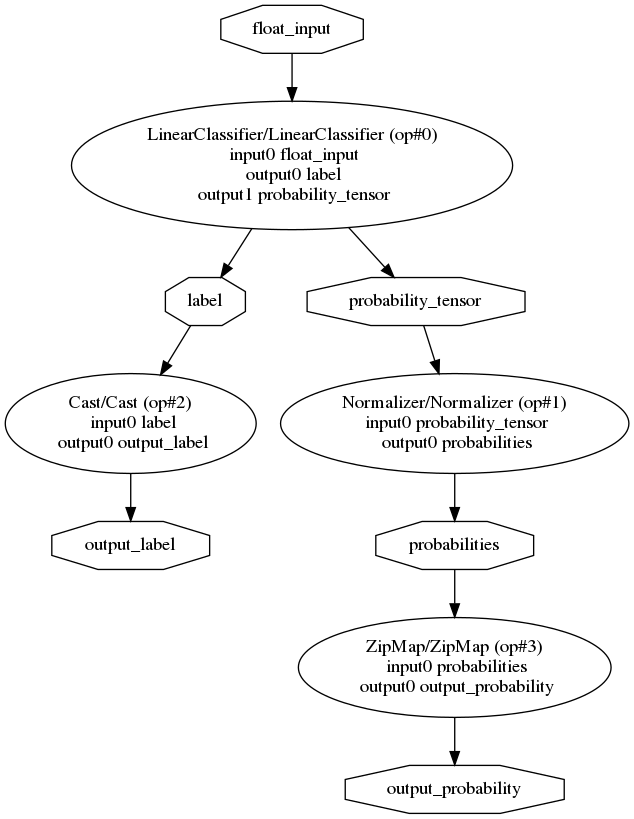

In [11]:
from IPython.display import Image
Image(graph_img)

# End of script